In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## Import Truth, Pred CSV

In [7]:
pred = pd.read_csv('/Users/mjin/Desktop/1008/Project/DeepLearning2020/saved/dl2020/dl2020_0503-003830_coef3/evaluation_result_efficientdet-d3_19944_val_132_133_0.05_0.5.csv')
truth = pd.read_csv('datasets/dl2020/annotation.csv')


## Scale Pred 

In [8]:
pred['x_pred'], pred['y_pred'], pred['w_pred'], pred['h_pred'] = [float(i.split(',')[0][1:]) for i in pred['bbox']], [float(i.split(',')[1]) for i in pred['bbox']], [float(i.split(',')[2]) for i in pred['bbox']], [float(i.split(',')[3][:-1]) for i in pred['bbox']]

pred['box_width'] = pred['w_pred']/612*80
pred['box_height'] = pred['h_pred']/768*80

pred['center_x'] = pred['x_pred']/612*80 + pred['box_width']/2 - 40
pred['center_y'] = 40 - pred['y_pred']/768*80 - pred['box_height']/2

pred.category_id -= 1


# Get a sample and boxes

In [29]:
def get_sample_boxes(scene, sample, pred, truth):
    

    pred = pred[pred.score > 0.075]


    pred_sample = pred[pred['scene_id'] == scene][pred['sample_id'] == sample]
    truth_sample = truth[truth['scene'] == scene][truth['sample'] == sample]
    
    truth_corners = truth_sample[['fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y','bl_y', 'br_y']].to_numpy()
    
    pred_corners = np.array([pred_sample.center_x + pred_sample.box_width/2, pred_sample.center_x + pred_sample.box_width/2,\
        pred_sample.center_x - pred_sample.box_width/2, pred_sample.center_x - pred_sample.box_width/2,\
        pred_sample.center_y + pred_sample.box_height/2, pred_sample.center_y - pred_sample.box_height/2,\
        pred_sample.center_y + pred_sample.box_height/2, pred_sample.center_y - pred_sample.box_height/2]).T
    
    
    truth_boxes = torch.as_tensor(truth_corners).view(-1, 2, 4)
    pred_boxes = torch.as_tensor(pred_corners).view(-1, 2, 4)
    
    return pred_sample, truth_sample, pred_boxes, truth_boxes
    
    

In [45]:
pred_sample, truth_sample, pred_boxes, truth_boxes = get_sample_boxes(133, 100, pred, truth)

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [46]:
truth_sample.shape

(12, 15)

In [47]:
pred_sample.shape

(113, 14)

## Calculate Score

In [48]:
def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull
    
    return a.intersection(b).area / a.union(b).area

In [49]:
def compute_ats_bounding_boxes(boxes1, boxes2):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    boxes1_max_x = boxes1[:, 0].max(dim=1)[0]
    boxes1_min_x = boxes1[:, 0].min(dim=1)[0]
    boxes1_max_y = boxes1[:, 1].max(dim=1)[0]
    boxes1_min_y = boxes1[:, 1].min(dim=1)[0]

    boxes2_max_x = boxes2[:, 0].max(dim=1)[0]
    boxes2_min_x = boxes2[:, 0].min(dim=1)[0]
    boxes2_max_y = boxes2[:, 1].max(dim=1)[0]
    boxes2_min_y = boxes2[:, 1].min(dim=1)[0]

    condition1_matrix = (boxes1_max_x.unsqueeze(1) > boxes2_min_x.unsqueeze(0))
    condition2_matrix = (boxes1_min_x.unsqueeze(1) < boxes2_max_x.unsqueeze(0))
    condition3_matrix = (boxes1_max_y.unsqueeze(1) > boxes2_min_y.unsqueeze(0))
    condition4_matrix = (boxes1_min_y.unsqueeze(1) < boxes2_max_y.unsqueeze(0))
    condition_matrix = condition1_matrix * condition2_matrix * condition3_matrix * condition4_matrix

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
            if condition_matrix[i][j]:
                iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])

    iou_max = iou_matrix.max(dim=0)[0]

    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    total_threat_score = 0
    total_weight = 0
    for threshold in iou_thresholds:
        tp = (iou_max > threshold).sum()
        threat_score = tp * 1.0 / (num_boxes1 + num_boxes2 - tp)
        total_threat_score += 1.0 / threshold * threat_score
        total_weight += 1.0 / threshold

    average_threat_score = total_threat_score / total_weight
    
    return average_threat_score

In [50]:
compute_ats_bounding_boxes(pred_boxes, truth_boxes)

tensor(0.)

## Visualization - Dots and Boxes

In [51]:
# plt.figure(figsize = (3,3))
# plt.scatter(truth_sample['center_x'], truth_sample['center_y'])
# plt.xlim(-40, 40)
# plt.ylim(-40, 40)
# plt.grid()

In [52]:
# plt.figure(figsize = (3,3))
# plt.scatter(pred_sample['center_x'], pred_sample['center_y'])
# plt.xlim(-40, 40)
# plt.ylim(-40, 40)
# plt.grid()

In [53]:
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

In [54]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)

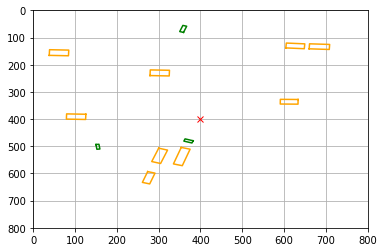

In [55]:
fig, ax = plt.subplots()

ax.plot(400, 400, 'x', color="red")


for i, bb in enumerate(truth_boxes):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[[int(i) for i in truth_sample.category_id][i]])  
    
ax.set_xlim(0, 800)
ax.set_ylim(800, 0)
plt.grid()

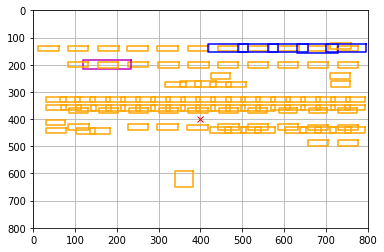

In [56]:
fig, ax = plt.subplots()

ax.plot(400, 400, 'x', color="red")


for i, bb in enumerate(pred_boxes):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[[int(i) for i in pred_sample.category_id][i]])  
    
ax.set_xlim(0, 800)
ax.set_ylim(800, 0)
plt.grid()

# Category_id Distribution

In [ ]:
plt.hist(truth_sample.category_id)

In [ ]:
plt.hist(pred_sample.category_id)